# Assignment on Feature Engineering (L6)

This assignment has been adapted from the course **Feature Engineering for Machine Learning in Python** On DataCamp. 

We will explore what feature engineering is and how to get started with applying it to real-world data. We will be working with a modified subset of the [Stackoverflow survey response data](https://insights.stackoverflow.com/survey/2018/#overview). This data set records the details, and preferences of thousands of users of the StackOverflow website. 

## Creating Features 
---

In [0]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score,mean_squared_error as MSE,roc_auc_score,confusion_matrix,classification_report,roc_curve 
from xgboost import XGBClassifier
import xgboost as xgb
SEED=1

---
### Inspect your data
---


In [0]:
# Load the data which has been stored as a CSV on the URL given below:
so_survey_csv = 'https://assets.datacamp.com/production/repositories/3752/datasets/19699a2441073ad6459bf5e3e17690e2cae86cf1/Combined_DS_v10.csv'

# Import so_survey_csv into so_survey_df
so_survey_df = pd.read_csv(so_survey_csv)

Instructions: For the `so_survey_df` DataFrame, 
* Print its shape and its first five rows. 
* Print the data type of each column.  

In [37]:
print(so_survey_df.shape)
print(so_survey_df.head())
print(so_survey_df.dtypes)

(999, 11)
      SurveyDate  ...   RawSalary
0  2/28/18 20:20  ...         NaN
1  6/28/18 13:26  ...   70,841.00
2    6/6/18 3:37  ...         NaN
3    5/9/18 1:06  ...   21,426.00
4  4/12/18 22:41  ...  £41,671.00

[5 rows x 11 columns]
SurveyDate                     object
FormalEducation                object
ConvertedSalary               float64
Hobby                          object
Country                        object
StackOverflowJobsRecommend    float64
VersionControl                 object
Age                             int64
Years Experience                int64
Gender                         object
RawSalary                      object
dtype: object


---
### Selecting specific data types
---
Often a data set will contain columns with several different data types (like the one we are working with). The majority of machine learning models require us to have a consistent data type across features. Similarly, most feature engineering techniques are applicable to only one type of data at a time. 

Instructions:

* Create a subset of `so_survey_df` consisting of only the numeric (int and float) columns and save it as `so_numeric_df`. 
* Print the column names contained in `so_numeric_df`. 

In [38]:
so_numeric_df=so_survey_df.select_dtypes(include =['float64','int']) 
print(so_numeric_df.columns)

Index(['ConvertedSalary', 'StackOverflowJobsRecommend', 'Age',
       'Years Experience'],
      dtype='object')


---
### One-hot encoding and dummy variables
---
To use categorical variables in a machine learning model, we first need to represent them in a quantitative way. The two most common approaches are to one-hot encode the variables using or to use dummy variables. 

Instructions:

* One-hot encode the `Country` column of `so_survey_df` DataFrame, adding "OH" as a prefix for each column.
* Create dummy variables for the `Country` column, adding "DM" as a prefix for each column.

In [39]:
pd.get_dummies(so_survey_df,columns=['Country'],prefix='OH')
pd.get_dummies(so_survey_df,columns=['Country'],prefix='DM',drop_first=True)

,SurveyDate,FormalEducation,ConvertedSalary,Hobby,StackOverflowJobsRecommend,VersionControl,Age,Years Experience,Gender,RawSalary,DM_India,DM_Ireland,DM_Russia,DM_South Africa,DM_Spain,DM_Sweeden,DM_UK,DM_USA,DM_Ukraine
0,2/28/18 20:20,Bachelor's degree (BA. BS. B.Eng.. etc.),NaN,Yes,NaN,Git,21,13,Male,NaN,0,0,0,1,0,0,0,0,0
1,6/28/18 13:26,Bachelor's degree (BA. BS. B.Eng.. etc.),70841.0,Yes,7.0,Git;Subversion,38,9,Male,"70,841.00",0,0,0,0,0,1,0,0,0
2,6/6/18 3:37,Bachelor's degree (BA. BS. B.Eng.. etc.),NaN,No,8.0,Git,45,11,NaN,NaN,0,0,0,0,0,1,0,0,0
3,5/9/18 1:06,Some college/university study without earning ...,21426.0,Yes,NaN,Zip file back-ups,46,12,Male,"21,426.00",0,0,0,0,0,1,0,0,0
4,4/12/18 22:41,Bachelor's degree (BA. BS. B.Eng.. etc.),41671.0,Yes,8.0,Git,39,7,Male,"£41,671.00",0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,10/19/18 13:50,Some college/university study without earning ...,NaN,Yes,NaN,Subversion,45,10,Male,NaN,0,0,0,0,0,0,0,0,0
995,4/14/18 15:31,Bachelor's degree (BA. BS. B.Eng.. etc.),58746.0,No,8.0,Git,27,16,Male,"58,746.00",0,0,0,0,1,0,0,0,0
996,3/21/18 6:34,Bachelor's degree (BA. BS. B.Eng.. etc.),55000.0,Yes,NaN,Git,54,16,Male,"$55,000.00",0,0,0,0,0,0,0,1,0
997,2/5/18 20:01,Bachelor's degree (BA. BS. B.Eng.. etc.),NaN,Yes,NaN,Git;Subversion,23,9,NaN,NaN,0,0,0,0,0,1,0,0,0


---
### Dealing with uncommon categories
---
Some features can have many different categories but a very uneven distribution of their occurrences. Take for example Data Science's favorite languages to code in, some common choices are Python, R, and Julia, but there can be individuals with bespoke choices, like FORTRAN, C etc. In these cases, we may not want to create a feature for each value, but only the more common occurrences.

Instructions:

* Extract the `Country` column of `so_survey_df` as a series and assign it to `countries`.
* Find the counts of each category in the newly created `countries` series.

In [40]:
countries=so_survey_df['Country']
country_counts=countries.value_counts()
print(country_counts)

South Africa    166
USA             164
Spain           134
Sweeden         119
France          115
Russia           97
UK               95
India            95
Ukraine           9
Ireland           5
Name: Country, dtype: int64


Instructions:

* Create a mask for values occurring less than 10 times in `country_counts`.
* Print the first 5 rows of the mask.

In [41]:
mask=countries.isin(country_counts[country_counts<10].index)
mask.head()

0    False
1    False
2    False
3    False
4    False
Name: Country, dtype: bool

Instructions:

* Label values occurring less than the `mask` cutoff as 'Other'.
* Print the new category counts in `countries`.

In [42]:
countries[mask]='Other'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [43]:
country_counts=countries.value_counts()
country_counts

South Africa    166
USA             164
Spain           134
Sweeden         119
France          115
Russia           97
UK               95
India            95
Other            14
Name: Country, dtype: int64

---
### Binarizing columns
---
While numeric values can often be used without any feature engineering, there will be cases when some form of manipulation can be useful. For example on some occasions, we might not care about the magnitude of a value but only care about its direction, or if it exists at all. In these situations, we will want to binarize a column. In the `so_survey_df` data, we have a large number of survey respondents that are working voluntarily (without pay). We will create a new column titled `Paid_Job` indicating whether each person is paid (their salary is greater than zero).

Instructions:

* Create a new column called `Paid_Job` filled with zeros.
* Replace all the `Paid_Job` values with a 1 where the corresponding `ConvertedSalary` is greater than 0.

In [44]:
so_survey_df['Paid_Job']=0
so_survey_df.loc[so_survey_df['ConvertedSalary']>0,'Paid_Job']=1
so_survey_df

,SurveyDate,FormalEducation,ConvertedSalary,Hobby,Country,StackOverflowJobsRecommend,VersionControl,Age,Years Experience,Gender,RawSalary,Paid_Job
0,2/28/18 20:20,Bachelor's degree (BA. BS. B.Eng.. etc.),NaN,Yes,South Africa,NaN,Git,21,13,Male,NaN,0
1,6/28/18 13:26,Bachelor's degree (BA. BS. B.Eng.. etc.),70841.0,Yes,Sweeden,7.0,Git;Subversion,38,9,Male,"70,841.00",1
2,6/6/18 3:37,Bachelor's degree (BA. BS. B.Eng.. etc.),NaN,No,Sweeden,8.0,Git,45,11,NaN,NaN,0
3,5/9/18 1:06,Some college/university study without earning ...,21426.0,Yes,Sweeden,NaN,Zip file back-ups,46,12,Male,"21,426.00",1
4,4/12/18 22:41,Bachelor's degree (BA. BS. B.Eng.. etc.),41671.0,Yes,UK,8.0,Git,39,7,Male,"£41,671.00",1
...,...,...,...,...,...,...,...,...,...,...,...,...
994,10/19/18 13:50,Some college/university study without earning ...,NaN,Yes,France,NaN,Subversion,45,10,Male,NaN,0
995,4/14/18 15:31,Bachelor's degree (BA. BS. B.Eng.. etc.),58746.0,No,Spain,8.0,Git,27,16,Male,"58,746.00",1
996,3/21/18 6:34,Bachelor's degree (BA. BS. B.Eng.. etc.),55000.0,Yes,USA,NaN,Git,54,16,Male,"$55,000.00",1
997,2/5/18 20:01,Bachelor's degree (BA. BS. B.Eng.. etc.),NaN,Yes,Sweeden,NaN,Git;Subversion,23,9,NaN,NaN,0


---
### Binning values
---
For many continuous values we will care less about the exact value of a numeric column, but instead care about the bucket it falls into. This can be useful when plotting values, or simplifying your machine learning models. It is mostly used on continuous variables where accuracy is not the biggest concern e.g. age, height, wages.

Bins are created using `pd.cut(df['column_name'], bins)` where bins can be an integer specifying the number of evenly spaced bins, or a list of bin boundaries.

Instructions:

* Bin the value of the `ConvertedSalary` column in `so_survey_df` into 5 equal bins, in a new column called `equal_binned`.
* Print the first five rows of both columns: `ConvertedSalary` and `equal_binned`. 

In [45]:
so_survey_df['equal_binned']=pd.cut(so_survey_df['ConvertedSalary'],5)
print(so_survey_df['equal_binned'].head())
print(so_survey_df['ConvertedSalary'].head())

0                    NaN
1    (-2000.0, 400000.0]
2                    NaN
3    (-2000.0, 400000.0]
4    (-2000.0, 400000.0]
Name: equal_binned, dtype: category
Categories (5, interval[float64]): [(-2000.0, 400000.0] < (400000.0, 800000.0] < (800000.0, 1200000.0] <
                                    (1200000.0, 1600000.0] < (1600000.0, 2000000.0]]
0        NaN
1    70841.0
2        NaN
3    21426.0
4    41671.0
Name: ConvertedSalary, dtype: float64


Instructions:

* Bin the `ConvertedSalary` column using the boundaries in the list bins and label the bins using `labels` in a new column called `boundary_binned`. 
* Print the first 5 rows of the `boundary_binned` column. 

In [46]:
# Specify the boundaries of the bins
bins = [-np.inf, 10000, 50000, 100000, 150000, np.inf]
# Bin labels
labels = ['Very low', 'Low', 'Medium', 'High', 'Very high']
boundary_binned=pd.cut(so_survey_df['ConvertedSalary'],labels=labels,bins=bins)
print(boundary_binned.head())

0       NaN
1    Medium
2       NaN
3       Low
4       Low
Name: ConvertedSalary, dtype: category
Categories (5, object): [Very low < Low < Medium < High < Very high]


## Dealing with Messy Data
---

---
### How sparse is my data?
---
Most data sets contain missing values, often represented as NaN (Not a Number). If we are working with Pandas, we can easily check how many missing values exist in each column.

Let's find out how many of the developers taking the survey chose to enter their age (found in the `Age` column of `so_survey_df`) and their gender (`Gender` column of `so_survey_df`).

Instructions:

* Subset the `so_survey_df` DataFrame to only include the `Age` and `Gender` columns.
* Print the number of non-missing values in both columns.

In [47]:
sub_df=so_survey_df[['Age','Gender']]
print(sub_df.notnull().sum())

Age       999
Gender    693
dtype: int64


---
### Finding the missing values
---
While having a summary of how much of your data is missing can be useful, often we will need to find the exact locations of these missing values. Using the same subset of the StackOverflow data from the last exercise (`sub_df`), we will show how a value can be flagged as missing.

Instructions:

* Print the first 10 entries of the `sub_df` DataFrame.
* Print the locations of the missing values in the first 10 rows of this DataFrame.
* Print the locations of the non-missing values in the first 10 rows.

In [48]:
# Print the first 10 entries of the sub_df DataFrame.
print(sub_df.head(10))

   Age  Gender
0   21    Male
1   38    Male
2   45     NaN
3   46    Male
4   39    Male
5   39    Male
6   34    Male
7   24  Female
8   23    Male
9   36     NaN


In [49]:
# Print the locations of the missing values in the first 10 rows of this DataFrame.
print(sub_df.head(10).isna())

     Age  Gender
0  False   False
1  False   False
2  False    True
3  False   False
4  False   False
5  False   False
6  False   False
7  False   False
8  False   False
9  False    True


In [50]:
# Print the locations of the non-missing values in the first 10 rows.
print(sub_df.head(10).notnull())

    Age  Gender
0  True    True
1  True    True
2  True   False
3  True    True
4  True    True
5  True    True
6  True    True
7  True    True
8  True    True
9  True   False


---
### Listwise deletion
---
The simplest way to deal with missing values in our dataset when they are occurring entirely at random is to remove those rows, also called 'listwise deletion'.

Depending on the use case, we will sometimes want to remove all missing values in our data while other times we may want to only remove a particular column if too many values are missing in that column.

Instructions:

* Print the number of rows and columns in `so_survey_df`.
* Drop all rows with missing values in `so_survey_df`.
* Drop all columns with missing values in `so_survey_df`.
* Drop all rows in `so_survey_df` where `Gender` is missing.

In [51]:
# Print the number of rows and columns in so_survey_df.
print(so_survey_df.shape)

(999, 13)


In [52]:
# Drop all rows with missing values in so_survey_df
drop_all_rows=so_survey_df.dropna()
drop_all_rows.shape

(264, 13)

In [53]:
# Drop all columns with missing values in so_survey_df.
drop_all_columns=so_survey_df.dropna(axis=1)
drop_all_columns.shape

(999, 8)

In [54]:
# Drop all rows in so_survey_df where Gender is missing.
drop_gender=so_survey_df.dropna(subset=['Gender'])
drop_gender.shape

(693, 13)

---
### Replacing missing values with constants
---
While removing missing data entirely maybe a correct approach in many situations, this may result in a lot of information being omitted from your models.

We may find categorical columns where the missing value is a valid piece of information in itself, such as someone refusing to answer a question in a survey. In these cases, we can fill all missing values with a new category entirely, for example 'No response given'.

Instructions:

* Print the count of occurrences of each category in `so_survey_df`'s `Gender` column.
* Replace all missing values in the `Gender` column with the string 'Not Given'. Make changes to the original DataFrame.
* Print the count of occurrences of updated category in `so_survey_df`'s `Gender` column.

In [55]:
# Print the count of occurrences of each category in so_survey_df's Gender column.
so_survey_df['Gender'].value_counts() 

Male                                                                         632
Female                                                                        53
Transgender                                                                    2
Female;Male                                                                    2
Female;Transgender                                                             1
Female;Male;Transgender;Non-binary. genderqueer. or gender non-conforming      1
Male;Non-binary. genderqueer. or gender non-conforming                         1
Non-binary. genderqueer. or gender non-conforming                              1
Name: Gender, dtype: int64

In [0]:
# Replace all missing values in the Gender column with the string 'Not Given'. Make changes to the original DataFrame.
so_survey_df['Gender'].fillna("Not Given", inplace = True) 

In [57]:
# Print the count of occurrences of updated category in so_survey_df's Gender column.
so_survey_df['Gender'].value_counts()

Male                                                                         632
Not Given                                                                    306
Female                                                                        53
Transgender                                                                    2
Female;Male                                                                    2
Female;Transgender                                                             1
Female;Male;Transgender;Non-binary. genderqueer. or gender non-conforming      1
Male;Non-binary. genderqueer. or gender non-conforming                         1
Non-binary. genderqueer. or gender non-conforming                              1
Name: Gender, dtype: int64

---
### Filling continuous missing values
---
Earlier, we dealt with different methods of removing data missing values and filling in missing values with a fixed string. These approaches are valid in many cases, particularly when dealing with categorical columns but have limited use when working with continuous values. In these cases, it may be most valid to fill the missing values in the column with a value calculated from the entries present in the column.

Instructions:

* Print the first five rows of the `StackOverflowJobsRecommend` column of `so_survey_df`.
* Replace the missing values in the `StackOverflowJobsRecommend` column with its mean. Make changes directly to the original DataFrame.
* Round the decimal values that we introduced in the `StackOverflowJobsRecommend` column.

In [58]:
# Print the first five rows of the StackOverflowJobsRecommend column of so_survey_df.
print(so_survey_df['StackOverflowJobsRecommend'].head())

0    NaN
1    7.0
2    8.0
3    NaN
4    8.0
Name: StackOverflowJobsRecommend, dtype: float64


In [59]:
# Replace the missing values in the StackOverflowJobsRecommend column with its mean. Make changes directly to the original DataFrame.
so_survey_df['StackOverflowJobsRecommend'].fillna(so_survey_df['StackOverflowJobsRecommend'].mean(),inplace=True)
so_survey_df['StackOverflowJobsRecommend']

0      7.061602
1      7.000000
2      8.000000
3      7.061602
4      8.000000
         ...   
994    7.061602
995    8.000000
996    7.061602
997    7.061602
998    7.061602
Name: StackOverflowJobsRecommend, Length: 999, dtype: float64

In [60]:
# Round the decimal values that we introduced in the StackOverflowJobsRecommend column.
so_survey_df['StackOverflowJobsRecommend'].round()

0      7.0
1      7.0
2      8.0
3      7.0
4      8.0
      ... 
994    7.0
995    8.0
996    7.0
997    7.0
998    7.0
Name: StackOverflowJobsRecommend, Length: 999, dtype: float64

---
### Dealing with stray characters (I)
---
In this exercise, we will work with the `RawSalary` column of so_survey_df which contains the wages of the respondents along with the currency symbols and commas, such as $42,000. When importing data from Microsoft Excel, more often that not we will come across data in this form.

Instructions:

* Remove the commas (,) from the `RawSalary` column.
* Remove the dollar ($) signs from the `RawSalary` column.
* Print the first five rows of updated `RawSalary` column. 

In [0]:
# Remove the commas (,) from the RawSalary column
so_survey_df['RawSalary']=so_survey_df['RawSalary'].str.replace(',','')

In [0]:
# Remove the dollar ($) signs from the RawSalary column.
so_survey_df['RawSalary']=so_survey_df['RawSalary'].str.replace('$','')

In [63]:
print(so_survey_df['RawSalary'].head())

0          NaN
1     70841.00
2          NaN
3     21426.00
4    £41671.00
Name: RawSalary, dtype: object


---
### Dealing with stray characters (II)
---
In the last exercise, we could tell quickly based off of the `df.head()` call which characters were causing an issue. In many cases this will not be so apparent. There will often be values deep within a column that are preventing us from casting a column as a numeric type so that it can be used in a model or further feature engineering.

One approach to finding these values is to force the column to the data type desired using `pd.to_numeric()`, coercing any values causing issues to `NaN`, Then filtering the DataFrame by just the rows containing the `NaN` values.

Try to cast the `RawSalary` column as a float and it will fail as an additional character can now be found in it. Find the character and remove it so the column can be cast as a float.

Instructions:

* Attempt to convert the `RawSalary` column of `so_survey_df` to numeric values coercing all failures into null values.
* Find the indexes of the rows containing `NaN`s.
* Print the rows in `RawSalary` based on these indexes.

In [0]:
# Attempt to convert the column to numeric values
numeric_vals = pd.to_numeric(so_survey_df['RawSalary'], errors='coerce')

In [65]:
# Find the indexes of the rows containing NaNs.
idx=numeric_vals.isna()
idx

0       True
1      False
2       True
3      False
4       True
       ...  
994     True
995    False
996    False
997     True
998    False
Name: RawSalary, Length: 999, dtype: bool

In [66]:
# Print the rows in RawSalary based on these indexes.
print(so_survey_df['RawSalary'][idx])

0            NaN
2            NaN
4      £41671.00
6            NaN
8            NaN
         ...    
989          NaN
990          NaN
992          NaN
994          NaN
997          NaN
Name: RawSalary, Length: 401, dtype: object


Instructions:

* Did you notice the pound (£) signs in the `RawSalary` column? Remove these signs like we did in the previous exercise.

In [67]:
so_survey_df['RawSalary']=so_survey_df['RawSalary'].str.replace('£','')
so_survey_df['RawSalary']

0             NaN
1        70841.00
2             NaN
3        21426.00
4        41671.00
          ...    
994           NaN
995      58746.00
996      55000.00
997           NaN
998    1000000.00
Name: RawSalary, Length: 999, dtype: object

---
### Method chaining
---
When applying multiple operations on the same column (like in the previous exercises), you made the changes in several steps, assigning the results back in each step. However, when applying multiple successive operations on the same column, you can "chain" these operations together for clarity and ease of management. This can be achieved by calling multiple methods sequentially:
```
# Method chaining
df['column'] = df['column'].method1().method2().method3()

# Same as 
df['column'] = df['column'].method1()
df['column'] = df['column'].method2()
df['column'] = df['column'].method3()
```

Instructions:

* Remove the commas (`,`) from the `RawSalary` column of `so_survey_df`.
* Remove the dollar (`$`) signs from the `RawSalary` column.
* Remove the pound (`£`) signs from the `RawSalary` column.
* Convert the `RawSalary` column to float.

In [68]:
so_survey_df['RawSalary']=so_survey_df['RawSalary'].str.replace(',','').str.replace('$','').str.replace('£','').astype(float)
print(so_survey_df['RawSalary'])

0            NaN
1        70841.0
2            NaN
3        21426.0
4        41671.0
         ...    
994          NaN
995      58746.0
996      55000.0
997          NaN
998    1000000.0
Name: RawSalary, Length: 999, dtype: float64


## Conforming to Statistical Assumptions
---

---
### What does your data look like?
---
Up until now we have focused on creating new features and dealing with issues in our data. Feature engineering can also be used to make the most out of the data that we already have and use it more effectively when creating machine learning models.
Many algorithms may assume that our data is normally distributed, or at least that all our columns are on the same scale. This will often not be the case, e.g. one feature may be measured in thousands of dollars while another would be number of years. In this exercise, we will create plots to examine the distributions of some numeric columns in the `so_survey_df` DataFrame. 

In [0]:
so_numeric_df = so_survey_df[['ConvertedSalary', 'Age', 'Years Experience']]

Instructions:

* Generate a histogram of all columns in the `so_numeric_df` DataFrame.
* Generate box plots of the `Age` and `Years Experience` columns in the `so_numeric_df` DataFrame.
* Generate a box plot of the `ConvertedSalary` column in the `so_numeric_df`.
* Plot pairwise relationships (using `sns.pairplot`) in the `so_numeric_df`.

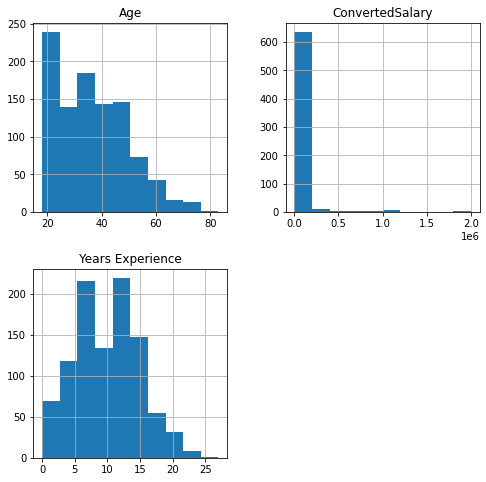

In [70]:
# Generate a histogram of all columns in the so_numeric_df DataFrame.
so_numeric_df.hist(figsize=(8,8))
plt.show()

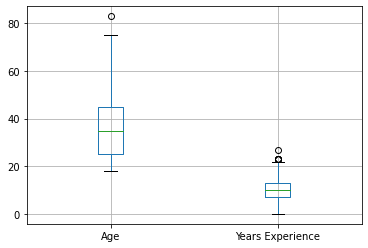

In [71]:
# Generate box plots of the Age and Years Experience columns in the so_numeric_df DataFrame
so_survey_df[['Age', 'Years Experience']].boxplot()
plt.show()

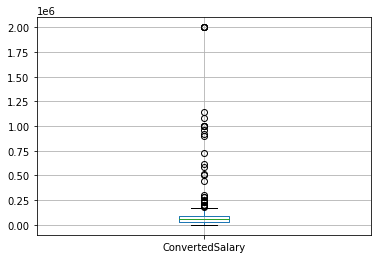

In [72]:
# Generate a box plot of the ConvertedSalary column in the so_numeric_df.
so_survey_df[['ConvertedSalary']].boxplot()
plt.show()

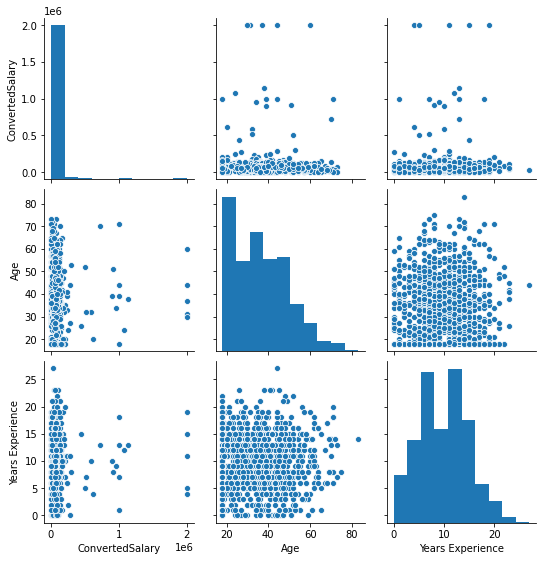

In [73]:
# Plot pairwise relationships (using sns.pairplot) in the so_numeric_df.
sns.pairplot(so_numeric_df)
plt.show()

---
### Normalization
---
In normalization we linearly scale the entire column between 0 and 1, with 0 corresponding with the lowest value in the column, and 1 with the largest. When using scikit-learn (the most commonly used machine learning library in Python) we can use a `MinMaxScaler` to apply normalization. (It is called this as it scales our values between a minimum and maximum value.)

Instructions:

* Fit the `MinMaxScaler` on the `Age` column of `so_numeric_df`.
* Transform the same column with the scaler you just fit.

In [0]:
# Import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

In [75]:
# Instantiate MinMaxScaler
MM_scaler = MinMaxScaler()
MM_scaler.fit(so_survey_df[['Age']])
so_survey_df['Age_MM']=MM_scaler.transform(so_survey_df[['Age']])
print(so_survey_df[['Age','Age_MM']].head())

   Age    Age_MM
0   21  0.046154
1   38  0.307692
2   45  0.415385
3   46  0.430769
4   39  0.323077


---
### Standardization
---
While normalization can be useful for scaling a column between two data points, it is hard to compare two scaled columns if even one of them is overly affected by outliers. One commonly used solution to this is called standardization, where instead of having a strict upper and lower bound, you center the data around its mean, and calculate the number of standard deviations away from mean each data point is.

Instructions:

* Fit the `StandardScaler` on the `Age` column of `so_numeric_df`.
* Transform the same column with the scaler we just fit.

In [0]:
# Import StandardScaler
from sklearn.preprocessing import StandardScaler

In [77]:
# Instantiate StandardScaler
SS_scaler = StandardScaler()
SS_scaler.fit(so_survey_df[['Age']])
so_survey_df['Age_SS']=SS_scaler.transform(so_survey_df[['Age']])
print(so_survey_df[['Age','Age_SS']].head())

   Age    Age_SS
0   21 -1.132431
1   38  0.150734
2   45  0.679096
3   46  0.754576
4   39  0.226214


---
### Log transformation
---
In the previous exercises we scaled the data linearly, which will not affect the data's shape. This works great if our data is normally distributed (or closely normally distributed), an assumption that a lot of machine learning models make. Sometimes we will work with data that closely conforms to normality, e.g the height or weight of a population. On the other hand, many variables in the real world do not follow this pattern e.g, wages or age of a population. 

Now, we will use a log transform on the `ConvertedSalary` column in the `so_numeric_df` DataFrame as it has a large amount of its data centered around the lower values, but contains very high values also. These distributions are said to have a long right tail.

Instructions:

* Fit the `PowerTransformer` on the `ConvertedSalary` column of `so_numeric_df`.
* Transform the same column with the scaler we just fit.

In [0]:
# Import PowerTransformer
from sklearn.preprocessing import PowerTransformer

   ConvertedSalary_PT  ConvertedSalary
0                 NaN              NaN
1            0.312939          70841.0
2                 NaN              NaN
3           -0.652182          21426.0
4           -0.135589          41671.0


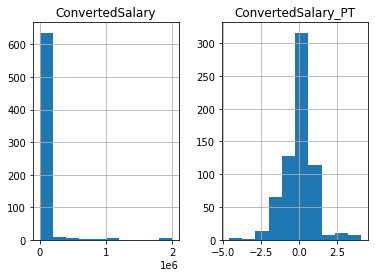

In [79]:
# Instantiate PowerTransformer
pow_trans = PowerTransformer()
pow_trans.fit(so_survey_df[['ConvertedSalary']])
so_survey_df['ConvertedSalary_PT']=pow_trans.transform(so_survey_df[['ConvertedSalary']])
print(so_survey_df[['ConvertedSalary_PT','ConvertedSalary']].head())
so_survey_df[['ConvertedSalary_PT','ConvertedSalary']].hist()
plt.show()

---
### Percentage based outlier removal
---
One way to ensure a small portion of data is not having an overly adverse effect is by removing a certain percentage of the largest and/or smallest values in the column. This can be achieved by finding the relevant quantile and trimming the data using it with a mask. This approach is particularly useful if we are concerned that the highest values in our dataset should be avoided. When using this approach, we must remember that even if there are no outliers, this will still remove the same top N percentage from the dataset.

Instructions:

* Find the 95th quantile of the `ConvertedSalary` column in `so_numeric_df` DataFrame.
* Trim the `so_numeric_df` DataFrame to retain all rows where `ConvertedSalary` is less than it's 95th quantile and store this as `trimmed_df`.
* Plot the histogram of `so_numeric_df[['ConvertedSalary']]`.
* Plot the histogram of `trimmed_df[['ConvertedSalary']]`

In [0]:
# Find the 95th quantile
quantile = so_numeric_df['ConvertedSalary'].quantile(0.95)

In [0]:
# Trim the so_numeric_df DataFrame to retain all rows where ConvertedSalary is less than it's 95th quantile and store this as trimmed_df.
trimmed_df=so_numeric_df[so_numeric_df['ConvertedSalary']<quantile]

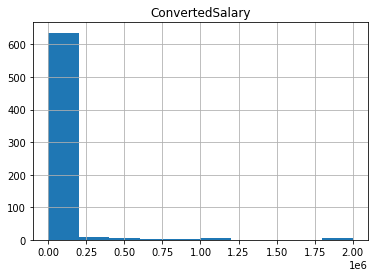

In [82]:
# Plot the histogram of so_numeric_df[['ConvertedSalary']]
so_numeric_df[['ConvertedSalary']].hist()
plt.show()

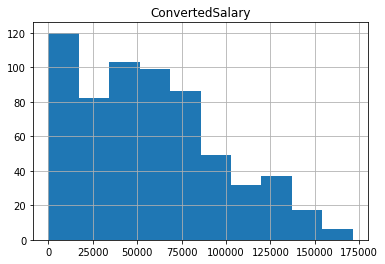

In [83]:
# Plot the histogram of trimmed_df[['ConvertedSalary']]
trimmed_df[['ConvertedSalary']].hist()
plt.show()

## Dealing with Text Data
---

---
### Cleaning up your text
---
Unstructured text data cannot be directly used in most analyses. Multiple steps need to be taken to go from a long free form string to a set of numeric columns in the right format that can be ingested by a machine learning model. The first step of this process is to standardize the data and eliminate any characters that could cause problems later on in your analytic pipeline.

Here, we will be working with a new dataset containing the inaugural speeches of the presidents of the United States loaded as `speech_df`, with the speeches stored in the `text` column.

In [84]:
speech_df = pd.read_csv('https://raw.githubusercontent.com/shala2020/shala2020.github.io/master/Lecture_Materials/Assignments/MachineLearning/L6/inaugural_speeches.csv')
speech_df.head()

,Name,Inaugural Address,Date,text
0,George Washington,First Inaugural Address,"Thursday, April 30, 1789",Fellow-Citizens of the Senate and of the House...
1,George Washington,Second Inaugural Address,"Monday, March 4, 1793",Fellow Citizens: I AM again called upon by th...
2,John Adams,Inaugural Address,"Saturday, March 4, 1797","WHEN it was first perceived, in early times, t..."
3,Thomas Jefferson,First Inaugural Address,"Wednesday, March 4, 1801",Friends and Fellow-Citizens: CALLED upon to u...
4,Thomas Jefferson,Second Inaugural Address,"Monday, March 4, 1805","PROCEEDING, fellow-citizens, to that qualifica..."


Instructions:

* Print the first 5 rows of the `text` column in `speech_df` DataFrame to see the free text fields.
* Replace all non letter characters in the `text` column with a whitespace and add it as a new column `text_clean` in the `speech_df` DataFrame. 
* Make all characters in the newly created `text_clean` column lower case.
* Print the first 5 rows of the `text_clean` column. 

In [85]:
# Print the first 5 rows of the text column in speech_df DataFrame to see the free text fields.
speech_df.text.head()

0    Fellow-Citizens of the Senate and of the House...
1    Fellow Citizens:  I AM again called upon by th...
2    WHEN it was first perceived, in early times, t...
3    Friends and Fellow-Citizens:  CALLED upon to u...
4    PROCEEDING, fellow-citizens, to that qualifica...
Name: text, dtype: object

In [0]:
# Replace all non letter characters in the text column with a whitespace and add it as a new column text_clean in the speech_df DataFrame.
speech_df['text_clean']=speech_df['text'].str.replace('[^a-zA-Z]',' ');

In [0]:
# Make all characters in the newly created text_clean column lower case.
speech_df['text_clean']=speech_df['text_clean'].str.lower()

In [88]:
# Print the first 5 rows of the text_clean column.
print(speech_df['text_clean'].head())

0    fellow citizens of the senate and of the house...
1    fellow citizens   i am again called upon by th...
2    when it was first perceived  in early times  t...
3    friends and fellow citizens   called upon to u...
4    proceeding  fellow citizens  to that qualifica...
Name: text_clean, dtype: object


---
### High level text features
---
Once the text has been cleaned and standardized we can begin creating features from the data. The most fundamental information we can calculate about free form text is its size, such as its length and number of words. 

Instructions:

* Record the character length of each speech (`speech_df['text_clean']`) and store it in a new `char_count` column.
* Record the word count of each speech in the `word_count` column.
* Record the average word length of each speech in the `avg_word_length` column.
* Print the first 5 rows of the columns: `text_clean`, `char_cnt`, `word_cnt`, `avg_word_length`


In [0]:
# Record the character length of each speech (speech_df['text_clean']) and store it in a new char_count column.
speech_df['char_count']=speech_df['text_clean'].str.len()

In [0]:
# Record the word count of each speech in the word_count column.
# speech_df['word_count']=speech_df['text_clean'].str.count(' ')+1
speech_df['word_count']=speech_df['text_clean'].str.split().str.len()

In [0]:
# Record the average word length of each speech in the avg_word_length column.
speech_df['avg_word_length']=speech_df['char_count']/+speech_df['word_count']

In [92]:
# Print the first 5 rows of the columns: text_clean, char_cnt, word_cnt, avg_word_length
print(speech_df[['text_clean','char_count','word_count','avg_word_length']].head())

                                          text_clean  ...  avg_word_length
0  fellow citizens of the senate and of the house...  ...         6.016760
1  fellow citizens   i am again called upon by th...  ...         5.829630
2  when it was first perceived  in early times  t...  ...         5.971158
3  friends and fellow citizens   called upon to u...  ...         5.843318
4  proceeding  fellow citizens  to that qualifica...  ...         5.948363

[5 rows x 4 columns]


---
### Counting words (I)
---
Once high level information has been recorded we can begin creating features based on the actual content of each text, as given below: 

* For each unique word in the dataset a column is created.
* For each entry, the number of times this word occurs is counted and the count value is entered into the respective column.

These "count" columns can then be used to train machine learning models.

Instructions:

* Import `CountVectorizer` from `sklearn.feature_extraction.text`.
* Instantiate `CountVectorizer` and assign it to 'cv'.
* Fit the vectorizer to the `text_clean` column.
* Print the feature names generated by the vectorizer and find the number of features.


In [0]:
# Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Instantiate CountVectorizer
cv = CountVectorizer()

In [0]:
# Fit the vectorizer to the text_clean column.
X=cv.fit(speech_df['text_clean'])

In [95]:
# Print the feature names generated by the vectorizer
print(cv.get_feature_names())

['abandon', 'abandoned', 'abandonment', 'abate', 'abdicated', 'abeyance', 'abhorring', 'abide', 'abiding', 'abilities', 'ability', 'abject', 'able', 'ably', 'abnormal', 'abode', 'abolish', 'abolished', 'abolishing', 'aboriginal', 'aborigines', 'abound', 'abounding', 'abounds', 'about', 'above', 'abraham', 'abreast', 'abridging', 'abroad', 'absence', 'absent', 'absolute', 'absolutely', 'absolutism', 'absorb', 'absorbed', 'absorbing', 'absorbs', 'abstain', 'abstaining', 'abstract', 'abstractions', 'absurd', 'abundance', 'abundant', 'abundantly', 'abuse', 'abused', 'abuses', 'academies', 'accept', 'acceptance', 'accepted', 'accepting', 'accepts', 'access', 'accessible', 'accession', 'accident', 'accidental', 'accidents', 'acclaim', 'accommodation', 'accommodations', 'accompanied', 'accompany', 'accomplish', 'accomplished', 'accomplishing', 'accomplishment', 'accomplishments', 'accord', 'accordance', 'accorded', 'according', 'accordingly', 'accords', 'account', 'accountability', 'accountab

In [96]:
# find the number of features.
# print(X.toarray().shape)
print(len(cv.get_feature_names()))

9043


---
### Counting words (II)
---
Once the vectorizer has been fit to the data, it can be used to transform the text to an array representing the word counts. 

Instructions:

* Apply the vectorizer ('cv' in the previous exercise) to the `text_clean` column.
* Convert this transformed (sparse) array into a `numpy` array with counts and print it. 

In [0]:
# Apply the vectorizer ('cv' in the previous exercise) to the text_clean column.
Y=cv.transform(speech_df['text_clean'])

In [98]:
# Convert this transformed (sparse) array into a numpy array with counts and print it.
print(Y.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


---
### Limiting your features
---
As we have seen, using the `CountVectorizer` with its default settings creates a feature for every single word in our corpus. This can create far too many features, often including ones that will provide very little analytical value.

For this purpose `CountVectorizer` has parameters that you can set to reduce the number of features:

* `min_df` : Use only words that occur in more than this percentage of documents. This can be used to remove outlier words that will not generalize across texts.
* `max_df` : Use only words that occur in less than this percentage of documents. This is useful to eliminate very common words that occur in every corpus without adding value such as "and" or "the".

Instructions:

* Limit the number of features in the `CountVectorizer` by setting the minimum number of documents a word can appear to 20% and the maximum to 80%.
* Fit and apply the vectorizer on `text_clean` column in one step.
* Convert this transformed (sparse) array into a `numpy` array with counts and print the dimensions of the new reduced array.
* Did you notice that the number of features (unique words) greatly reduced from 9043 to 818?


In [0]:
# Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Specify arguements to limit the number of features generated
cv = CountVectorizer(min_df=0.2, max_df=0.8)

In [0]:
# Fit and apply the vectorizer on text_clean column in one step.
X=cv.fit_transform(speech_df['text_clean'])

In [101]:
# Convert this transformed (sparse) array into a numpy array with counts and print the dimensions of the new reduced array.
cv_array=X.toarray()
print(cv_array)
print(cv_array.shape)

[[ 0  0  0 ...  5  0  9]
 [ 0  0  0 ...  0  0  1]
 [ 0  0  0 ...  0  0  1]
 ...
 [ 0  1  0 ... 14  1  3]
 [ 0  0  0 ...  5  1  0]
 [ 0  0  0 ... 14  1 11]]
(58, 818)


In [0]:
# Did you notice that the number of features (unique words) greatly reduced from 9043 to 818?
# Yes

---
### Text to DataFrame
---
Now that we have generated these count based features in an array we will need to reformat them so that they can be combined with the rest of the dataset. This can be achieved by converting the array into a pandas DataFrame, with the feature names you found earlier as the column names, and then concatenate it with the original DataFrame.


Instructions:

* Create a DataFrame `cv_df` containing the `cv_array` as the values and the feature names as the column names.
* Add the prefix `Counts_` to the column names for ease of identification.
* Concatenate this DataFrame (`cv_df`) to the original DataFrame (`speech_df`) column wise.


In [0]:
# Create a DataFrame cv_df containing the cv_array as the values and the feature names as the column names.
cv_df=pd.DataFrame(data=cv_array,columns=cv.get_feature_names())

In [0]:
# Add the prefix Counts_ to the column names for ease of identification.
cv_df=cv_df.add_prefix('Counts_')


In [105]:
# Concatenate this DataFrame (cv_df) to the original DataFrame (speech_df) column wise.
pd.concat([speech_df,cv_df],axis=1)

,Name,Inaugural Address,Date,text,text_clean,char_count,word_count,avg_word_length,Counts_abiding,Counts_ability,Counts_able,Counts_about,Counts_above,Counts_abroad,Counts_accept,Counts_accomplished,Counts_achieve,Counts_across,Counts_act,Counts_action,Counts_acts,Counts_add,Counts_adequate,Counts_administration,Counts_adopted,Counts_advance,Counts_advantage,Counts_affairs,Counts_afford,Counts_after,Counts_again,Counts_against,Counts_age,Counts_ago,Counts_agriculture,Counts_aid,Counts_alike,Counts_almighty,Counts_almost,Counts_alone,...,Counts_vital,Counts_voice,Counts_want,Counts_war,Counts_wars,Counts_washington,Counts_waste,Counts_way,Counts_ways,Counts_weak,Counts_wealth,Counts_weight,Counts_welfare,Counts_were,Counts_what,Counts_whatever,Counts_where,Counts_wherever,Counts_whether,Counts_while,Counts_whole,Counts_whom,Counts_whose,Counts_willing,Counts_wisdom,Counts_wise,Counts_wisely,Counts_wish,Counts_within,Counts_without,Counts_women,Counts_words,Counts_work,Counts_wrong,Counts_year,Counts_years,Counts_yet,Counts_you,Counts_young,Counts_your
0,George Washington,First Inaugural Address,"Thursday, April 30, 1789",Fellow-Citizens of the Senate and of the House...,fellow citizens of the senate and of the house...,8616,1432,6.016760,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,2,0,0,1,1,0,0,1,1,0,0,0,0,0,1,0,0,...,0,2,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,2,0,0,0,0,0,1,0,5,0,9
1,George Washington,Second Inaugural Address,"Monday, March 4, 1793",Fellow Citizens: I AM again called upon by th...,fellow citizens i am again called upon by th...,787,135,5.829630,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,John Adams,Inaugural Address,"Saturday, March 4, 1797","WHEN it was first perceived, in early times, t...",when it was first perceived in early times t...,13871,2323,5.971158,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,3,1,0,1,0,0,3,0,1,1,0,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0,1,0,1,5,3,2,1,0,0,1,3,0,0,0,0,1,0,1,0,3,0,0,0,0,2,3,0,0,0,1
3,Thomas Jefferson,First Inaugural Address,"Wednesday, March 4, 1801",Friends and Fellow-Citizens: CALLED upon to u...,friends and fellow citizens called upon to u...,10144,1736,5.843318,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,2,0,2,0,1,0,0,0,2,1,0,1,0,0,0,0,1,...,2,1,1,1,0,0,0,0,0,0,0,0,0,0,5,1,3,0,0,0,2,1,2,0,2,1,0,1,1,2,0,0,1,2,0,0,2,7,0,7
4,Thomas Jefferson,Second Inaugural Address,"Monday, March 4, 1805","PROCEEDING, fellow-citizens, to that qualifica...",proceeding fellow citizens to that qualifica...,12902,2169,5.948363,0,0,1,0,0,0,0,0,0,0,3,1,0,1,0,1,0,1,0,3,1,0,2,6,0,0,1,0,0,0,0,2,...,0,0,1,3,1,0,0,0,0,0,0,1,0,0,4,0,1,0,3,0,1,2,3,0,2,0,0,1,4,2,0,0,0,0,2,2,2,4,0,4
5,James Madison,First Inaugural Address,"Saturday, March 4, 1809",UNWILLING to depart from examples of the most ...,unwilling to depart from examples of the most ...,7003,1179,5.939779,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,1,0,1,0,1,...,0,0,0,1,1,0,0,0,0,0,0,1,0,3,1,0,0,0,0,0,0,1,2,0,0,0,1,0,1,2,0,0,0,0,0,0,0,0,0,0
6,James Madison,Second Inaugural Address,"Thursday, March 4, 1813",ABOUT to add the solemnity of an oath to the o...,about to add the solemnity of an oath to the o...,7148,1211,5.902560,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,...,0,1,0,15,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,4,0,0,1,0,0,0,0,0,0,0
7,James Monroe,First Inaugural Address,"Tuesday, March 4, 1817",I SHOULD be destitute of feeling if I was not ...,i should be destitute of feeling if i was not ...,19894,3382,5.882318,0,0,2,1,0,1,0,0,0,0,1,1,0,2,2,2,0,1,1,0,1,0,1,9,0,0,1,2,0,1,1,1,...,0,0,1,10,3,0,0,0,0,0,0,0,1,0,8,1,0,0,1,4,3,3,1,1,0,2,1,0,5,3,0,0,3,0,0,2,0,0,0,0
8,James Monroe,Second Inaugural Address,"Monday, March 5, 1821",Fellow-Citizens: I SHALL not attempt to descr...,fellow citizens i shall not attempt to descr...,26322,4466,5.893865,0,1,1,1,0,0,0,0,0,0,0,0,1,2,4,2,1,0,3,0,2,4,1,2,0,1,1,3,2,1,2,0,...,1,0,0,16,2,0,1,1,0

---
### Tf-idf
---
While counts of occurrences of words can be useful to build models, words that occur many times may skew the results undesirably. To limit these common words from overpowering your model a form of normalization can be used. In this lesson we will be using **Term frequency-inverse document frequency** (**Tf-idf**). Tf-idf has the effect of reducing the value of common words, while increasing the weight of words that do not occur in many documents.

Instructions:

* Import `TfidfVectorizer` from `sklearn.feature_extraction.text`.
* Instantiate `TfidfVectorizer` while limiting the number of features to 100 and removing English stop words.
* Fit and apply the vectorizer on `text_clean` column in one step.
* Create a DataFrame `tv_df` containing the weights of the words and the feature names as the column names.
* Add the prefix `TFIDF_` to the column names for ease of identification.

In [0]:
# Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate TfidfVectorizer
tv = TfidfVectorizer(max_features=100, stop_words='english')

In [107]:
# Fit and apply the vectorizer on text_clean column in one step.
transform=tv.fit_transform(speech_df['text_clean'])
print(transform.toarray())

[[0.         0.13341519 0.         ... 0.         0.04592879 0.05269404]
 [0.         0.2610165  0.26609667 ... 0.         0.         0.        ]
 [0.         0.09243595 0.1570584  ... 0.         0.06364299 0.07301753]
 ...
 [0.03761807 0.         0.36891392 ... 0.18400376 0.17440593 0.0285851 ]
 [0.03897977 0.         0.30581431 ... 0.12710956 0.07745104 0.14809914]
 [0.06921321 0.03329018 0.67876212 ... 0.02821227 0.13752353 0.05259353]]


In [0]:
# Create a DataFrame tv_df containing the weights of the words and the feature names as the column names.
tv_df=pd.DataFrame(data=transform.toarray(),columns=tv.get_feature_names())

In [109]:
# Add the prefix TFIDF_ to the column names for ease of identification
tv_df.add_prefix('TFIDF_')

,TFIDF_action,TFIDF_administration,TFIDF_america,TFIDF_american,TFIDF_americans,TFIDF_believe,TFIDF_best,TFIDF_better,TFIDF_change,TFIDF_citizens,TFIDF_come,TFIDF_common,TFIDF_confidence,TFIDF_congress,TFIDF_constitution,TFIDF_country,TFIDF_day,TFIDF_duties,TFIDF_duty,TFIDF_equal,TFIDF_executive,TFIDF_faith,TFIDF_far,TFIDF_federal,TFIDF_fellow,TFIDF_force,TFIDF_foreign,TFIDF_free,TFIDF_freedom,TFIDF_future,TFIDF_general,TFIDF_god,TFIDF_good,TFIDF_government,TFIDF_great,TFIDF_high,TFIDF_history,TFIDF_home,TFIDF_hope,TFIDF_human,...,TFIDF_need,TFIDF_new,TFIDF_office,TFIDF_old,TFIDF_order,TFIDF_party,TFIDF_peace,TFIDF_people,TFIDF_place,TFIDF_policy,TFIDF_political,TFIDF_power,TFIDF_powers,TFIDF_present,TFIDF_president,TFIDF_principles,TFIDF_progress,TFIDF_prosperity,TFIDF_public,TFIDF_purpose,TFIDF_right,TFIDF_rights,TFIDF_secure,TFIDF_service,TFIDF_shall,TFIDF_spirit,TFIDF_state,TFIDF_states,TFIDF_strength,TFIDF_support,TFIDF_things,TFIDF_time,TFIDF_today,TFIDF_union,TFIDF_united,TFIDF_war,TFIDF_way,TFIDF_work,TFIDF_world,TFIDF_years
0,0.000000,0.133415,0.000000,0.105388,0.000000,0.000000,0.000000,0.000000,0.000000,0.229644,0.000000,0.000000,0.111079,0.000000,0.060755,0.229644,0.115098,0.064225,0.238637,0.063036,0.147280,0.000000,0.178978,0.000000,0.147528,0.000000,0.000000,0.098352,0.000000,0.101797,0.000000,0.000000,0.147528,0.367430,0.133183,0.000000,0.000000,0.000000,0.051787,0.126073,...,0.000000,0.049176,0.000000,0.000000,0.141458,0.070729,0.000000,0.174590,0.056532,0.138691,0.000000,0.050898,0.065448,0.315182,0.061880,0.063036,0.000000,0.064225,0.333237,0.000000,0.055540,0.050898,0.000000,0.063036,0.145021,0.000000,0.000000,0.103573,0.000000,0.000000,0.000000,0.045929,0.000000,0.136012,0.203593,0.000000,0.060755,0.000000,0.045929,0.052694
1,0.000000,0.261016,0.266097,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.179712,0.000000,0.000000,0.217318,0.000000,0.237725,0.179712,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.192418,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.179712,0.000000,0.233437,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.242128,0.000000,0.000000,0.000000,0.000000,0.170786,0.000000,0.000000,0.000000,0.000000,0.000000,0.246652,0.242128,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.567446,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.199157,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.092436,0.157058,0.073018,0.000000,0.000000,0.026112,0.060460,0.000000,0.106072,0.000000,0.056125,0.025654,0.196017,0.224501,0.212143,0.026582,0.029665,0.055113,0.058233,0.068028,0.082669,0.027556,0.000000,0.068143,0.000000,0.246496,0.045428,0.000000,0.023510,0.133321,0.000000,0.136285,0.339429,0.102528,0.027556,0.029116,0.000000,0.023920,0.058233,...,0.000000,0.022714,0.000000,0.000000,0.130678,0.130678,0.121696,0.403213,0.026112,0.000000,0.027556,0.117549,0.030230,0.058233,0.000000,0.058233,0.000000,0.059331,0.153921,0.000000,0.025654,0.023510,0.030230,0.058233,0.089313,0.153921,0.090691,0.215280,0.000000,0.116465,0.032030,0.021214,0.000000,0.062823,0.070529,0.024339,0.000000,0.000000,0.063643,0.073018
3,0.000000,0.092693,0.000000,0.000000,0.000000,0.090942,0.117831,0.045471,0.053335,0.223369,0.000000,0.084421,0.154348,0.000000,0.084421,0.127639,0.039983,0.089243,0.000000,0.175183,0.051163,0.082899,0.041449,0.059596,0.239161,0.048179,0.000000,0.102498,0.171970,0.035363,0.100268,0.000000,0.170829,0.382918,0.030844,0.124348,0.087591,0.045471,0.035980,0.000000,...,0.000000,0.000000,0.042992,0.000000,0.049140,0.000000,0.183051,0.060650,0.039277,0.000000,0.124348,0.141450,0.045471,0.000000,0.000000,0.131387,0.000000,0.044621,0.154348,0.000000,0.154348,0.070725,0.000000,0.000000,0.201512,0.000000,0.090942,0.000000,0.000000,0.131387,0.048179,0.000000,0.000000,0.094497,0.000000,0.036610,0.000000,0.039277,0.095729,0.000000
4,0.041334,0.039761,0.000000,0.031408,0.000000,

---
### Inspecting Tf-idf values
---
After creating Tf-idf features we will often want to understand what are the most highest scored words for each corpus. This can be achieved by isolating the row we want to examine and then sorting the the scores from high to low.

* Assign the first row of `tv_df` to `sample_row`.
* `sample_row` is now a series of weights assigned to words. Sort these values to print the top 5 highest-rated words.

In [110]:
# Isolate the row to be examined
sample_row = tv_df.iloc[0]
print(sample_row.sort_values(ascending=False).head())

government    0.367430
public        0.333237
present       0.315182
duty          0.238637
citizens      0.229644
Name: 0, dtype: float64


---
### Sentiment analysis
---
You have been given the tweets about US airlines. Making use of this data, your task is to predict whether a tweet contains 

* positive, 
* negative, or 
* neutral sentiment 

about the airline.

In [111]:
data_source_url = "https://raw.githubusercontent.com/shala2020/shala2020.github.io/master/Lecture_Materials/Assignments/MachineLearning/L6/Tweets.csv"
airline_tweets = pd.read_csv(data_source_url)
airline_tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Instructions:

* Draw a pie chart to see the number of tweets for each airline. 
* Draw a pie chart to see the distribution of sentiments across all the tweets. 
* Apply suitable data pre-processing steps to get rid of undesired symbols. This part has been done upto some extent.  
* Using `TfidfVectorizer` class, convert text features into TF-IDF feature vectors.
* `airline_sentiment` is the label and `text` is the feature. Apply suitable `train_test_split`, implement suitable machine learning classifier, and show the accuracy. 

Note: 

* For your convenience, the pre-processing of features have been done. 
* You are supposed to apply the vectorization on `processed_features` and implement ML algorithm. 

In [0]:
# Extracting features and label
features = airline_tweets.iloc[:, 10].values
labels = airline_tweets.iloc[:, 1].values

In [113]:
airline_tweets['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

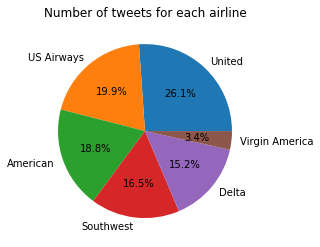

In [114]:
# Draw a pie chart to see the number of tweets for each airline.
airline_counts=airline_tweets['airline'].value_counts()
plt.pie(airline_counts, labels=airline_counts.index.tolist(),autopct='%1.1f%%',labeldistance=1.1)
plt.title('Number of tweets for each airline')
plt.show()

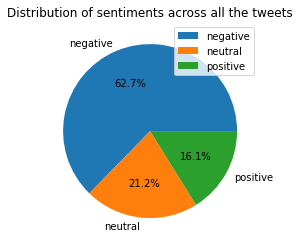

In [115]:
# Draw a pie chart to see the distribution of sentiments across all the tweets.
airline_sentiments=airline_tweets['airline_sentiment'].value_counts()
plt.pie(airline_sentiments, labels=airline_sentiments.index.tolist(),autopct='%1.1f%%')
plt.title('Distribution of sentiments across all the tweets')
plt.legend(loc='best')
plt.show()

In [0]:
import re 

processed_features = []

for sentence in range(0, len(features)):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(features[sentence]))

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)

    # Converting to Lowercase
    processed_feature = processed_feature.lower()

    processed_features.append(processed_feature)

In [117]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
# Using TfidfVectorizer class, convert text features into TF-IDF feature vectors.
# Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# Instantiate TfidfVectorizer
tv = TfidfVectorizer(max_features=2500, stop_words=stopwords.words('english'),min_df=7,max_df=.8,)
transform=tv.fit_transform(processed_features)
# Create a DataFrame tv_df containing the weights of the words and the feature names as the column names.
tv_df=pd.DataFrame(data=transform.toarray(),columns=tv.get_feature_names())

In [0]:
# airline_sentiment is the label and text is the feature. Apply suitable train_test_split, implement suitable machine learning classifier, and show the accuracy.
y=airline_tweets.iloc[:, 1].values
X=tv_df

In [0]:
# Split data into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= SEED)
# Instantiate individual classifiers
lr = LogisticRegression(random_state=SEED)
knn = KNN()
dt = DecisionTreeClassifier(random_state=SEED)
rf = RandomForestClassifier(n_estimators=300,random_state=SEED)
bc = BaggingClassifier(base_estimator=dt, n_estimators=300, n_jobs=-1,random_state=SEED,oob_score=True)
adb = AdaBoostClassifier(base_estimator=dt, n_estimators=100,random_state=SEED) 
gb= GradientBoostingClassifier(n_estimators=300, max_depth=1, random_state=SEED,subsample=0.8,max_features=0.2) 
xgb = xgb.XGBClassifier(learning_rate=0.01)
# Define a list called classifier that contains the tuples (classifier_name, classifier)
classifiers = [('Logistic Regression', lr),('K Nearest Neighbours', knn),
               ('Classification Tree', dt),('Random Forest',rf),
               ('Bagging Classifier',bc),('Adaboost',adb),('Gradient Boosting',gb),('Xtreme GB',xgb)]


In [121]:
import warnings
warnings.filterwarnings("ignore")
# Iterate over the defined list of tuples containing the classifiers
for clf_name, clf in classifiers:
  #fit clf to the training set
  clf.fit(X_train, y_train)
  # Predict the labels of the test set
  y_pred = clf.predict(X_test)
  # Evaluate the accuracy of clf on the test set
  print('{:s} : {:.3f}'.format(clf_name, accuracy_score(y_test, y_pred)))
  print(confusion_matrix(y_test,y_pred))
  print(classification_report(y_test, y_pred))

Logistic Regression : 0.783
[[1692  103   31]
 [ 279  299   33]
 [ 132   58  301]]
              precision    recall  f1-score   support

    negative       0.80      0.93      0.86      1826
     neutral       0.65      0.49      0.56       611
    positive       0.82      0.61      0.70       491

    accuracy                           0.78      2928
   macro avg       0.76      0.68      0.71      2928
weighted avg       0.78      0.78      0.77      2928

K Nearest Neighbours : 0.699
[[1473  291   62]
 [ 254  303   54]
 [ 113  108  270]]
              precision    recall  f1-score   support

    negative       0.80      0.81      0.80      1826
     neutral       0.43      0.50      0.46       611
    positive       0.70      0.55      0.62       491

    accuracy                           0.70      2928
   macro avg       0.64      0.62      0.63      2928
weighted avg       0.71      0.70      0.70      2928

Classification Tree : 0.669
[[1450  247  129]
 [ 284  250   77]
 [ 129 

KeyboardInterrupt: ignored

In [0]:
# So the accuarcy is 78.3 % for logistic regression which is highest amongh all the other classifiers.So we will use logistic regression for this model